# Data generator

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from yolo3.utils import get_random_data
from yolo3.model import preprocess_true_boxes

/Users/chaunguyen/anaconda2/envs/keras/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [3]:
annotation_path = '2012_train.txt'

In [4]:
with open(annotation_path) as f:
    lines = f.readlines()

In [5]:
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)

In [6]:
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'

input_shape = (416,416) # multiple of 32, hw

## data_generator function

In [7]:
val_split = 0.1
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

annotation_lines = lines[:num_train]

### get_random_data function

In [8]:
i = 1

(375, 500, 3)

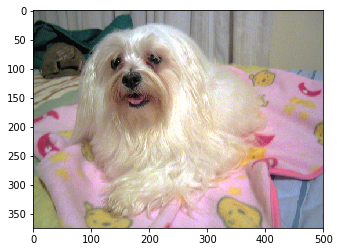

In [9]:
# Original image
annotation_line = annotation_lines[i]
line = annotation_line.split()
image = Image.open(line[0])
box = np.array([np.array(list(map(int,box.split(',')))) for box in line[1:]])

image = np.array(image)
plt.imshow(image)
image.shape

(416, 416, 3)

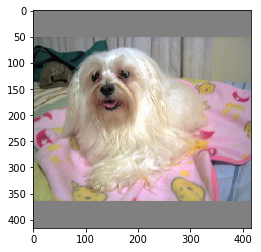

In [10]:
# Image with resizing and padding to become input_shape shape WITHOUT transforming image
# value be normalized = /255
image, box = get_random_data(annotation_line, input_shape, random=False)
plt.imshow(image)
image.shape

(416, 416, 3)

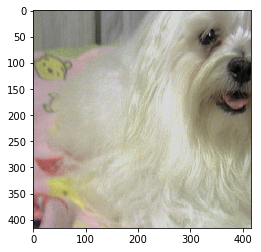

In [12]:
# Randomly Transforming image: resize, transition, flip and distort color
# value be normalized = /255
image, box = get_random_data(annotation_line, input_shape, random=True)
plt.imshow(image)
image.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(416, 416, 3)

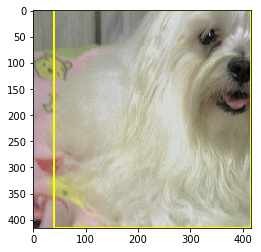

In [13]:
# Draw bounding box
k = 0
x1 = int(box[k][0])
y1 = int(box[k][1])
x2 = int(box[k][2])
y2 = int(box[k][3])

cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255, 0), 2)

plt.imshow(image)
image.shape

### preprocess_true_boxes function

In [14]:
box_data = []
box_data.append(box)
box_data = np.array(box_data)

class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

In [17]:
y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)

In [28]:
box_data

array([[[ 40.,   0., 416., 416.,  11.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]]])

In [26]:
len(y_true)

3

In [29]:
y_true[0].shape

(1, 13, 13, 3, 25)

In [30]:
y_true[1].shape

(1, 26, 26, 3, 25)

In [32]:
y_true[2].shape

(1, 52, 52, 3, 25)

In [34]:
anchors

array([[ 10.,  13.],
       [ 16.,  30.],
       [ 33.,  23.],
       [ 30.,  61.],
       [ 62.,  45.],
       [ 59., 119.],
       [116.,  90.],
       [156., 198.],
       [373., 326.]])

In [35]:
box_data[..., 0:2]

array([[[40.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]]])